## Notes

### Data Preprocessing
- Two final datasets, one for random forest one for boosting models.
- Random forest NaN values filled with KNN imputer and boosting filled with mean/mode to introduce diversity
### Model development and Tuning
- Random forest used from random forest submission
- XGB model trained on pre-determined large n-estimators
    - Learning rate set to categorical to reduce overhead of baysiean optimization overhead between iterations
- Catboost model train on continuous interval for everything
- Attempted ensemble models, they weren't as good
### Ad Hoc/Outlier tuning
- Best model at this point: average between random forest and catboost
- Cross validated predicted the train dataset and found residuals on train dataset, mostly predicting lower on outliers
- Found characteristics of high price airbnbs
- Found high variance predictions based upon rf, cat, and xgb
- Tuned high variance points based upon characteristics of high price in the train data, determined price through similar points in the train data
- Filtered test data based upon characteristics of high price points, tuned based upon similar points in the train data
- Found which models performed best on ceartain points in the data
- Remade final estimator as xgb did better on lower points, and I was manually tuning the higher points

## Read data

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_predict, cross_val_score, KFold, StratifiedKFold, cross_validate
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, \
roc_curve, auc, precision_score, recall_score, confusion_matrix, roc_auc_score, precision_recall_curve 
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from patsy import dmatrix
from joblib import parallel_backend
import itertools as it
import random
import warnings
warnings.filterwarnings("ignore")


#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
# import pydotplus
import time as tm

In [213]:
train = pd.read_csv('train_regression.csv')
test = pd.read_csv('test_regression.csv')
train.head()

,id,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,53872917,366516391,2018-04-09,"Chicago, IL",within an hour,96%,95%,f,Back of the Yards,11,...,5.00,5.00,4.28,4.83,f,9,1,8,0,0.33
1,39269663,50276775,2014-12-23,NaN,within an hour,100%,97%,f,Clearwater Beach,1141,...,NaN,NaN,NaN,NaN,t,58,0,58,0,NaN
2,556480733030442463,681680651,2020-03-08,NaN,within an hour,100%,100%,f,Lake View East,1,...,5.00,5.00,4.93,4.80,f,1,1,0,0,2.78
3,52397280,94345291,2015-10-22,"Chicago, IL",within an hour,100%,98%,f,Bucktown,55,...,4.38,4.23,4.54,3.85,t,55,55,0,0,3.61
4,745949202271858960,790998106,2021-04-04,"Chicago, IL",within an hour,100%,100%,t,Near South Side,74,...,4.83,4.85,4.74,4.72,t,74,74,0,0,3.24


## 1) Data pre-processing

Put the data pre-processing code. You don't need to explain it. You may use the same code from last quarter.

In [214]:
def clean_column(column):
    return pd.to_numeric(column.str.replace('%', '').str.replace('$', '').str.replace(',', ''), errors='coerce')
train[['host_response_rate', 'host_acceptance_rate', 'price']] = train[['host_response_rate', 'host_acceptance_rate', 'price']].apply(clean_column)
test[['host_response_rate', 'host_acceptance_rate']] = test[['host_response_rate', 'host_acceptance_rate']].apply(clean_column)

In [215]:
from datetime import datetime
train['host_since'] = pd.to_datetime(train['host_since'])
train['host_time'] = (datetime.now() - train['host_since']).dt.days
train.drop('host_since', axis=1, inplace=True)
test['host_since'] = pd.to_datetime(test['host_since'])
test['host_time'] = (datetime.now() - test['host_since']).dt.days
test.drop('host_since', axis=1, inplace=True)
train['first_review'] = pd.to_datetime(train['first_review'])
train['first_review_since'] = (datetime.now() - train['first_review']).dt.days
train.drop('first_review', axis=1, inplace=True)
test['first_review'] = pd.to_datetime(test['first_review'])
test['first_review_since'] = (datetime.now() - test['first_review']).dt.days
test.drop('first_review', axis=1, inplace=True)
train['last_review'] = pd.to_datetime(train['last_review'])
train['last_review_since'] = (datetime.now() - train['last_review']).dt.days
train.drop('last_review', axis=1, inplace=True)
test['last_review'] = pd.to_datetime(test['last_review'])
test['last_review_since'] = (datetime.now() - test['last_review']).dt.days
test.drop('last_review', axis=1, inplace=True)

In [216]:
train['bathroom_number'] = train['bathrooms_text'].str.extract(r'(\d+(\.\d+)?)')[0].astype(float)
train['bathroom_type'] = train['bathrooms_text'].apply(lambda x: 'shared' if 'shared' in str(x) else 'private')
train.drop('bathrooms_text', axis =1, inplace=True)
test['bathroom_number'] = test['bathrooms_text'].str.extract(r'(\d+(\.\d+)?)')[0].astype(float)
test['bathroom_type'] = test['bathrooms_text'].apply(lambda x: 'shared' if 'shared' in str(x) else 'private')
test.drop('bathrooms_text', axis =1, inplace=True)

In [217]:
def categorize_property(pt):
    pt = pt.lower()
    if any(keyword in pt for keyword in ["rental unit", "condo", "apartment"]):
        return "Apartment"
    elif any(keyword in pt for keyword in ["home", "house", "townhouse", "cottage", "bungalow"]):
        return "House"
    elif any(keyword in pt for keyword in ["serviced apartment", "villa", "luxury", "vacation home"]):
        return "Luxury"
    elif any(keyword in pt for keyword in ["hotel", "bed and breakfast", "hostel", "aparthotel"]):
        return "Hotel"
    elif any(keyword in pt for keyword in ["guest suite", "loft", "shared room"]):
        return "Shared Space"
    elif "guesthouse" in pt:
        return "Guesthouse"
    else:
        return "Other"
train['property_type_grouped'] = train['property_type'].apply(categorize_property)
test['property_type_grouped'] = test['property_type'].apply(categorize_property)

In [218]:
def categorize_neighborhood(nbh):
    downtown_core = ['Near North Side', 'Loop', 'Near South Side', 'New East Side', 'Streeterville', 'River North']
    residential_areas = ['West Ridge', 'South Shore', 'Montclare', 'Hyde Park', 'Rogers Park', 'Portage Park', 'Irving Park']
    upscale_suburban = ['Lake View', 'Lincoln Park', 'Near West Side', 'Bucktown', 'Wicker Park', 'Gold Coast', 'Old Town']
    cultural_unique = ['Uptown', 'Logan Square', 'Englewood', 'Chinatown', 'Pilsen', 'Little Italy', 'Bronzeville']
    if nbh in downtown_core:
        return 'Downtown/Core'
    elif nbh in residential_areas:
        return 'Residential Areas'
    elif nbh in upscale_suburban:
        return 'Upscale/Suburban'
    elif nbh in cultural_unique:
        return 'Cultural/Unique Areas'
    else:
        return 'Others'
train['neighbourhood_category'] = train['neighbourhood_cleansed'].apply(categorize_neighborhood)
test['neighbourhood_category'] = test['neighbourhood_cleansed'].apply(categorize_neighborhood)

In [219]:
top_2 = train['price'].nlargest(1).index
train = train.drop(index=top_2)
train_copy = train.copy()
test_copy = test.copy()
train_rf = train.copy()
test_rf = test.copy()
train_knn = train.copy()
test_knn = test.copy()
train_lin = train.copy()
test_lin = test.copy()

In [220]:
def fill_missing_values(df):
    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:
            df[column].fillna(df[column].mean(), inplace=True)
        else:
            mode_value = df[column].mode()[0]
            df[column].fillna(mode_value, inplace=True)
    return df

train_rf = fill_missing_values(train_rf)
test_rf = fill_missing_values(test_rf)

In [221]:
from category_encoders import TargetEncoder
categorical_cols = train.select_dtypes(include=['object', 'category']).columns
encoder = TargetEncoder()
train_encoded = train.copy()
train_encoded[categorical_cols] = encoder.fit_transform(train[categorical_cols], train['price'])
test_encoded = test.copy()
test_encoded[categorical_cols] = encoder.transform(test[categorical_cols])

In [222]:
col_names = train_encoded.drop(['price'], axis = 1).columns
imputer = KNNImputer(n_neighbors = 7)
train = imputer.fit_transform(train_encoded.drop(['price'], axis = 1))
test = imputer.transform(test_encoded)
train = pd.DataFrame(train).set_axis(col_names, axis=1)
test = pd.DataFrame(test).set_axis(col_names, axis=1)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
all_columns = train.drop(columns = ['id', 'host_id', 'host_location','host_neighbourhood']).columns.tolist()
numerical_columns = train.drop(columns = ['id', 'host_id', 'host_location','host_neighbourhood']).select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns_test = test.drop(columns = ['id', 'host_id', 'host_location','host_neighbourhood']).select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = train.drop(columns = ['id', 'host_id', 'host_location','host_neighbourhood']).select_dtypes(include=['object']).columns.tolist()
poly = PolynomialFeatures(degree=2, include_bias=False)

train_num_poly = poly.fit_transform(train[numerical_columns_test])
train_feature_names = poly.get_feature_names_out(numerical_columns_test)
train_num_poly_df = pd.DataFrame(train_num_poly, columns=train_feature_names, index=train.index)

scaler = StandardScaler()
train_num_poly_scaled = scaler.fit_transform(train_num_poly_df)
train_num_poly_scaled_df = pd.DataFrame(train_num_poly_scaled, columns=train_feature_names, index=train.index)

train_final = pd.concat([train[train.columns.difference(numerical_columns_test)], train_num_poly_scaled_df], axis=1)

test_num_poly = poly.transform(test[numerical_columns_test])
test_num_poly_df = pd.DataFrame(test_num_poly, columns=train_feature_names, index=test.index)

test_num_poly_scaled = scaler.transform(test_num_poly_df)
test_num_poly_scaled_df = pd.DataFrame(test_num_poly_scaled, columns=train_feature_names, index=test.index)

test_final = pd.concat([test[test.columns.difference(numerical_columns_test)], test_num_poly_scaled_df], axis=1)

In [224]:
X_train = train_final
y_train = train_encoded['price']
X_test = test_final

In [225]:
all_columns_rf = train_rf.drop(columns = ['id', 'host_id', 'host_location','host_neighbourhood']).columns.tolist()
numerical_columns_rf = train_rf.drop(columns = ['id', 'host_id', 'host_location','host_neighbourhood']).select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns_test_rf = test_rf.drop(columns = ['id', 'host_id', 'host_location','host_neighbourhood']).select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns_rf = train_rf.drop(columns = ['id', 'host_id', 'host_location','host_neighbourhood']).select_dtypes(include=['object']).columns.tolist()

In [226]:
from category_encoders import TargetEncoder
categorical_cols_rf = train_rf.select_dtypes(include=['object', 'category']).columns
encoder = TargetEncoder()
train_encoded_rf = train_rf.copy()
train_encoded_rf[categorical_cols_rf] = encoder.fit_transform(train_rf[categorical_cols_rf], train_rf['price'])
test_encoded_rf = test_rf.copy()
test_encoded_rf[categorical_cols_rf] = encoder.transform(test_rf[categorical_cols_rf])
train_encoded_rf.shape

(4999, 57)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
all_columns_rf = train_rf.drop(columns = ['id', 'host_id', 'host_location','host_neighbourhood']).columns.tolist()
numerical_columns_rf = train_rf.drop(columns = ['id', 'host_id', 'host_location','host_neighbourhood']).select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns_test_rf = test_rf.drop(columns = ['id', 'host_id', 'host_location','host_neighbourhood']).select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns_rf = train_rf.drop(columns = ['id', 'host_id', 'host_location','host_neighbourhood']).select_dtypes(include=['object']).columns.tolist()
poly = PolynomialFeatures(degree=2, include_bias=False)

train_num_poly_rf = poly.transform(train_rf[numerical_columns_test_rf])
train_feature_names_rf = poly.get_feature_names_out(numerical_columns_test_rf)
train_num_poly_df_rf = pd.DataFrame(train_num_poly_rf, columns=train_feature_names_rf, index=train_rf.index)

scaler = StandardScaler()
train_num_poly_scaled_rf = scaler.transform(train_num_poly_df_rf)
train_num_poly_scaled_df_rf = pd.DataFrame(train_num_poly_scaled_rf, columns=train_feature_names_rf, index=train_rf.index)

train_final_rf = pd.concat([train_rf[train_rf.columns.difference(numerical_columns_test_rf)], train_num_poly_scaled_df_rf], axis=1)
test_num_poly_rf = poly.transform(test_rf[numerical_columns_test_rf])
test_num_poly_df_rf = pd.DataFrame(test_num_poly_rf, columns=train_feature_names_rf, index=test_rf.index)

test_num_poly_scaled_rf = scaler.transform(test_num_poly_df_rf)
test_num_poly_scaled_df_rf = pd.DataFrame(test_num_poly_scaled_rf, columns=train_feature_names_rf, index=test_rf.index)

test_final_rf = pd.concat([test_rf[test_rf.columns.difference(numerical_columns_test_rf)], test_num_poly_scaled_df_rf], axis=1)

In [228]:
y_train_rf = train_encoded_rf['price']
X_train_rf = train_encoded_rf.drop(['price'], axis=1)
X_test_rf = test_encoded_rf

## 2) Hyperparameter tuning

**Paste the hyperparameter tuning code below. You must show at least one hyperparameter tuning procedure.**

[1.0, 0.0, 0.05, 10, 2000, 89.8353900282638, 0.235637598154002] 125.75421363366334


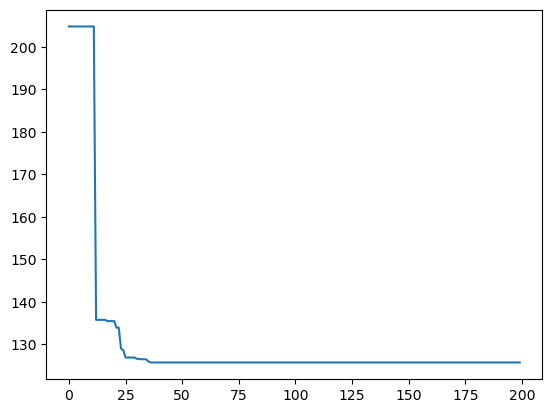

Optimal parameter values = OrderedDict([('colsample_bytree', 1.0), ('gamma', 0.0), ('learning_rate', 0.05), ('max_depth', 10), ('n_estimators', 2000), ('reg_lambda', 89.8353900282638), ('subsample', 0.235637598154002)])
Optimal score = -125.75421363366334


In [31]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold, RandomizedSearchCV
from scipy.stats import uniform, randint
from skopt.space import Real, Categorical, Integer
from IPython import display
import IPython
from skopt import BayesSearchCV

param_distributions = {
    'n_estimators': [2000],
    'max_depth': Integer(2, 10), 
    'learning_rate': Categorical([0.01, 0.05, 0.1]),  
    'reg_lambda': Real(0, 100),
    'gamma': Real(0, 1e9), 
    'subsample': Real(0,1),  
    'colsample_bytree': Real(0,1) 
}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
optimal_params = BayesSearchCV(
    estimator=xgb.XGBRegressor(random_state=42),
    search_spaces=param_distributions,
    n_iter=200,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    cv=cv,
    random_state=42
)
def monitor(optim_result):
    cv_values = pd.Series(optim_result['func_vals']).cummin()
    IPython.display.clear_output(wait = True)
    min_ind = pd.Series(optim_result['func_vals']).argmin()
    print(optim_result['x_iters'][min_ind], pd.Series(optim_result['func_vals']).min())
    sns.lineplot(cv_values)
    plt.show()
optimal_params.fit(X_train, y_train, callback = monitor)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal score =", optimal_params.best_score_)

**Paste the optimal hyperparameter values below.**

In [35]:
optimal_params.best_params_

OrderedDict([('colsample_bytree', 1.0),
             ('gamma', 0.0),
             ('learning_rate', 0.05),
             ('max_depth', 10),
             ('n_estimators', 2000),
             ('reg_lambda', 89.8353900282638),
             ('subsample', 0.235637598154002)])

## 3) Model

Using the optimal model hyperparameters, train the model, and paste the code below.

In [229]:
import xgboost as xgb
best_params = {'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 2000, 'reg_lambda': 89.8353900282638, 'subsample': 0.235637598154002}
XBGregressor = xgb.XGBRegressor(**best_params, random_state = 42)
XBGregressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [230]:
from sklearn.ensemble import RandomForestRegressor # Hyperparameters took from previous model
best_params = {'max_features': 0.16011953964897915, 'bootstrap': False}
rfregressor = RandomForestRegressor(**best_params, random_state = 42)
rfregressor.fit(X_train_rf, y_train_rf)

RandomForestRegressor(bootstrap=False, max_features=0.16011953964897915,
                      random_state=42)

In [ ]:
from catboost import CatBoostRegressor # Hyperparameters took from previous model
best_params = {'colsample_bylevel': 0.3143846551544746, 'learning_rate': 0.0049692079153122355, 'n_estimators': 7000,'num_leaves': 39, 'reg_lambda': 0.0, 'subsample': 0.9691644570113996}
catboostregressor = CatBoostRegressor(**best_params, grow_policy = 'Lossguide', random_state = 1)
catboostregressor.fit(X_train, y_train)

In [60]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_rf_cv = cross_val_predict(rfregressor, X_train_rf, y_train_rf, cv=cv, n_jobs=-1, method='predict')
y_pred_cat_cv = cross_val_predict(catboostregressor, X_train, y_train, cv=cv, n_jobs=-1, method='predict')
y_pred_xgb_cv = cross_val_predict(XBGregressor, X_train, y_train, cv=cv, n_jobs=-1, method='predict')

## 4) Any ad-hoc steps for further improving model accuracy


# Train data outlier finding

In [302]:
train_preds = 0.5*y_pred_rf_cv + 0.5*y_pred_cat_cv
train_resids = train_preds-train_copy['price']

In [562]:
train_resids[train_copy['neighbourhood_cleansed'] == 'Logan Square'].describe()

count     261.000000
mean       -1.148468
std       140.737105
min     -1620.820355
25%        -7.631425
50%         9.693376
75%        32.988750
max       593.015767
Name: price, dtype: float64

In [381]:
differences = pd.DataFrame(y_pred_rf_cv - y_pred_cat_cv, columns=['difference'])
positive_differences = differences[differences['difference'] > 0]
negative_differences = differences[differences['difference'] < 0]

In [561]:
neg_res = train_resids[negative_differences.index]
neg_res[train_copy['neighbourhood_cleansed'] == 'Logan Square'].describe()

count      89.000000
mean      -21.201546
std       225.350616
min     -1620.820355
25%       -16.024049
50%         7.847441
75%        36.922442
max       593.015767
Name: price, dtype: float64

In [401]:
pos_res = train_resids[positive_differences.index.drop(3129)]
pos_res[train_copy['neighbourhood_cleansed'] == 'Near West Side'].describe()

count    2853.000000
mean        7.344991
std        80.015002
min     -1011.116615
25%        -6.394549
50%         8.673764
75%        30.333276
max      1136.246759
Name: price, dtype: float64

In [380]:
train_resids.loc[[1823, 1327, 1654, 2374, 1626, 4888, 259, 207, 2148, 3836]]

1823   -1926.400187
1327     -57.344940
1654     485.435442
2374    -480.359650
1626   -3272.130378
4888      50.746685
259       47.293319
207     1136.246759
2148     543.253437
3836     -10.007149
Name: price, dtype: float64

In [233]:
np.abs(train_resids).nlargest(10)

523     4519.785544
1626    3272.130378
2327    2537.623462
2266    2328.154208
1823    1926.400187
1813    1620.820355
207     1136.246759
26      1070.991692
3377    1011.116615
1662     873.127233
Name: price, dtype: float64

In [234]:
train_copy.loc[[523, 1626, 2327, 2266, 1823, 1813, 207, 26, 3377, 1662],['reviews_per_month','bathroom_type', 'accommodates', 'beds', 'host_is_superhost', 'neighbourhood_cleansed','price']]

,reviews_per_month,bathroom_type,accommodates,beds,host_is_superhost,neighbourhood_cleansed,price
523,NaN,private,8,4.0,f,West Town,5000.0
1626,NaN,private,16,13.0,t,West Town,4500.0
2327,NaN,private,16,8.0,f,Bridgeport,3000.0
2266,0.93,private,12,6.0,t,Near North Side,3000.0
1823,NaN,private,12,7.0,t,Near North Side,3319.0
1813,1.33,private,12,5.0,t,Logan Square,1999.0
207,NaN,private,8,5.0,f,Lincoln Park,165.0
26,NaN,private,2,NaN,f,West Town,1200.0
3377,0.84,private,14,7.0,f,Irving Park,1347.0
1662,NaN,private,16,5.0,f,Lincoln Park,2218.0


# Train data high price finding

In [235]:
train_copy.loc[train_copy['price'] >=2000,['reviews_per_month','bathroom_type', 'accommodates', 'beds', 'host_is_superhost', 'neighbourhood_cleansed','price']]

,reviews_per_month,bathroom_type,accommodates,beds,host_is_superhost,neighbourhood_cleansed,price
118,0.18,private,14,7.0,f,West Town,2249.0
523,NaN,private,8,4.0,f,West Town,5000.0
1626,NaN,private,16,13.0,t,West Town,4500.0
1662,NaN,private,16,5.0,f,Lincoln Park,2218.0
1823,NaN,private,12,7.0,t,Near North Side,3319.0
2266,0.93,private,12,6.0,t,Near North Side,3000.0
2327,NaN,private,16,8.0,f,Bridgeport,3000.0


In [478]:
train_copy.loc[
    (train_copy['accommodates'] >= 14)&
    (train_copy['beds']>=7)&
    (train_copy['bathroom_number'] <=5)&
    (train_copy['neighbourhood_cleansed'].isin(['Loop'])) &
    (train_copy['number_of_reviews'] <=1)&
    (train_copy['reviews_per_month'].isna()),
    ['price']
]

,price
1018,399.0


In [477]:
test_copy.loc[
    (test_copy['accommodates'] >= 14)&
    (test_copy['beds']>=7)&
    (test_copy['bathroom_number'] <=5)&
    (test_copy['neighbourhood_cleansed'].isin(['Loop'])) &
    (test_copy['number_of_reviews']<=1) & 
    (test_copy['reviews_per_month'].isna()),:
]

,id,host_id,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_time,first_review_since,last_review_since,bathroom_number,bathroom_type,property_type_grouped,neighbourhood_category
3049,27166317,497520971,NaN,within an hour,99.0,99.0,t,West Loop/Greektown,71,88,...,0,0,NaN,1904,NaN,NaN,1.0,private,Apartment,Downtown/Core


In [293]:
train_copy.loc[[1662],['reviews_per_month','bathroom_type', 'accommodates', 'beds', 'host_is_superhost', 'neighbourhood_cleansed']]

,reviews_per_month,bathroom_type,accommodates,beds,host_is_superhost,neighbourhood_cleansed
1662,NaN,private,16,5.0,f,Lincoln Park


In [355]:
train_copy.loc[
    (train_copy['accommodates'] >= 14) &
    (train_copy['beds']>=9) &
    (train_copy['host_is_superhost'] == 't') &
    (train_copy['neighbourhood_cleansed'].isin(['Near North Side'])) &
    (train_copy['number_of_reviews'] <= 20),['price']
]

,price
1028,515.0
2799,824.0


In [353]:
test_copy.loc[
    (test_copy['accommodates'] >= 14) &
    (test_copy['beds']>=9) &
    (test_copy['host_is_superhost'] == 't') &
    (test_copy['neighbourhood_cleansed'].isin(['Near North Side'])) &
    (test_copy['number_of_reviews'] <= 20),:
]

,id,host_id,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_time,first_review_since,last_review_since,bathroom_number,bathroom_type,property_type_grouped,neighbourhood_category
2409,48806018,136570599,"Chicago, IL",within an hour,100.0,93.0,t,Gold Coast,2,2,...,0,0,1.27,2961,634.0,200.0,6.5,private,House,Downtown/Core


In [266]:
train_copy.loc[train_copy['neighbourhood_cleansed'] == 'Lincoln Park', ['reviews_per_month','bathroom_type', 'accommodates', 'beds', 'host_is_superhost', 'neighbourhood_cleansed','price']].sort_values(by = 'price')

,reviews_per_month,bathroom_type,accommodates,beds,host_is_superhost,neighbourhood_cleansed,price
3855,0.47,shared,1,1.0,t,Lincoln Park,31.0
263,2.20,shared,2,1.0,t,Lincoln Park,33.0
1938,NaN,private,2,1.0,f,Lincoln Park,36.0
3787,NaN,private,2,1.0,f,Lincoln Park,36.0
4757,NaN,private,2,1.0,f,Lincoln Park,36.0
...,...,...,...,...,...,...,...
4169,0.38,private,10,7.0,t,Lincoln Park,750.0
1650,NaN,private,4,2.0,t,Lincoln Park,754.0
2108,0.91,private,16,11.0,f,Lincoln Park,761.0
3279,0.97,private,4,3.0,t,Lincoln Park,765.0


In [269]:
test_copy.loc[test_copy['neighbourhood_cleansed'] == 'Lincoln Park', ['reviews_per_month','bathroom_type', 'accommodates', 'beds', 'host_is_superhost', 'neighbourhood_cleansed']]

,reviews_per_month,bathroom_type,accommodates,beds,host_is_superhost,neighbourhood_cleansed
0,NaN,private,14,1.0,f,Lincoln Park
64,4.55,private,2,1.0,f,Lincoln Park
111,0.54,private,3,1.0,t,Lincoln Park
121,0.86,private,6,2.0,t,Lincoln Park
131,2.71,private,4,3.0,NaN,Lincoln Park
...,...,...,...,...,...,...
3269,2.21,private,3,2.0,t,Lincoln Park
3279,3.17,private,3,2.0,f,Lincoln Park
3298,1.36,private,4,2.0,t,Lincoln Park
3305,0.07,private,2,1.0,t,Lincoln Park


##### Insights, reviews NaN or very low, private bathroom_type, high accomodates ~12, high beds, neighbourhoods (West Town, Near North Side, maybe lincoln park and bridge port)

In [333]:
train_resids[train_copy['neighbourhood_cleansed'] == 'West Town'].describe()

count     483.000000
mean       -9.443091
std       285.561275
min     -4519.785544
25%       -13.518155
50%        10.316736
75%        42.762406
max       627.729955
Name: price, dtype: float64

# Determining Outliers Through prediction variance

In [ ]:
y_pred_test_xg = XBGregressor.predict(X_test)
y_pred_test_rf = rfregressor.predict(X_test_rf)
y_pred_test_cat = catboostregressor.predict(X_test)
y_preds = np.column_stack((y_pred_test_rf, y_pred_test_cat, y_pred_test_xg))

In [ ]:
predictions = np.vstack((y_pred_test_xg, y_pred_test_rf, y_pred_test_cat))
std_dev = np.std(predictions, axis=0)

In [237]:
submission = pd.read_csv('sample_submission.csv')
result_df = pd.DataFrame({
    'id': submission['id'],
    'std_dev': std_dev
})
result_df['std_dev'].nlargest(10).index

Index([2101, 2261, 363, 2779, 149, 1933, 621, 2018, 603, 2270], dtype='int64')

In [ ]:
# Looking at the predictions of the high deviation points, also looked at original data from above, right after reading that data
submission.loc[[2101, 2261, 363, 2779, 149, 1933, 621, 2018, 603, 2270], 'predicted']

2101    192.468816
2261    194.306662
363     191.718483
2779     40.436780
149     186.976946
1933    140.731497
621     102.222409
2018    142.476982
603      92.279131
2270    165.299763
Name: predicted, dtype: float64

In [240]:
test_copy.loc[[2101, 2261, 363, 2779, 149, 1933, 621, 2018, 603, 2270],['reviews_per_month','bathroom_type', 'accommodates', 'beds', 'host_is_superhost', 'neighbourhood_cleansed']]

,reviews_per_month,bathroom_type,accommodates,beds,host_is_superhost,neighbourhood_cleansed
2101,0.10,private,16,4.0,f,West Town
2261,0.02,private,8,3.0,f,Norwood Park
363,NaN,private,16,11.0,t,West Town
2779,0.87,private,12,7.0,f,Forest Glen
149,0.33,shared,2,1.0,f,Lake View
1933,0.05,private,4,11.0,f,Near North Side
621,0.62,private,16,3.0,f,Greater Grand Crossing
2018,1.17,private,14,4.0,t,West Town
603,3.33,private,10,5.0,t,Jefferson Park
2270,NaN,private,8,4.0,f,West Town


In [241]:
# Finding: 2101 low review, private bathroom, high accomodates, beds kinda high, west town

In [ ]:
train_copy.loc[train_copy['neighbourhood_cleansed'] == 'West Town',['price']].price.nlargest(5)

523     5000.0
1626    4500.0
118     2249.0
4144    1500.0
4936    1290.0
Name: price, dtype: float64

In [243]:
(4500+1290)/2 # Determined value of 2101 through mean of 2 highest outlier prices, determined to round down due to the presence of 3 more points that are lower

2895.0

In [244]:
# 2261, 2779, 149, 621, 603 decided not to touch because of neighbourhood, 2261 was determined to be 250, when linear worked as outlier for Norwood Park
# 1933, 2270 not touched due to while being in west town and near north side, 1933 had a really low accomodates (only other train point like that had NaN beds aswell) and 2270 had low accomodates and beds

In [245]:
(10*4500+512)/11# Determined value of 363 by weighted average of the two values (one outlier weighted x10) value found to be similar, rounded to nearest 100

4137.454545454545

In [246]:
# Determined value of 2018 by the 5th largest value from west town. Only one similar value in the train data set that was much lower, so I decided to pick the 5th largest train price rather than an even higher outlier after looking at the distribution of prices

In [247]:
submission.loc[[2101, 2261, 363, 2779, 149, 1933, 621, 2018, 603, 2270],['predicted']]

,predicted
2101,192.468816
2261,194.306662
363,191.718483
2779,40.436780
149,186.976946
1933,140.731497
621,102.222409
2018,142.476982
603,92.279131
2270,165.299763


# Determine if models perform better in specific areas

In [248]:
xg_resids = y_pred_xgb_cv-train_copy['price']
cat_resids = y_pred_cat_cv-train_copy['price']
rf_resids = y_pred_rf_cv-train_copy['price']

In [367]:
pd.DataFrame(y_pred_rf_cv)[0].nlargest(5).index

Index([301, 958, 2197, 3334, 2326], dtype='int64')

In [249]:
train_copy.loc[np.abs(rf_resids).nsmallest(10).index,['reviews_per_month','bathroom_type', 'accommodates', 'beds', 'host_is_superhost', 'neighbourhood_cleansed','price']]

,reviews_per_month,bathroom_type,accommodates,beds,host_is_superhost,neighbourhood_cleansed,price
50,NaN,private,4,2.0,f,Near North Side,213.0
1555,NaN,private,1,1.0,f,Woodlawn,42.0
1579,NaN,private,1,1.0,f,Woodlawn,42.0
1916,NaN,private,2,NaN,f,Near North Side,82.0
1943,0.03,shared,2,1.0,f,East Garfield Park,38.0
1977,NaN,shared,2,1.0,f,East Garfield Park,38.0
2269,NaN,private,1,1.0,f,Woodlawn,42.0
2421,NaN,private,1,1.0,f,Woodlawn,42.0
2584,NaN,private,1,1.0,f,Woodlawn,42.0
2987,NaN,private,4,1.0,f,Near North Side,140.0


In [479]:
train_copy.loc[
    ((train_copy['accommodates'] <= 4) | (train_copy['reviews_per_month'].isna()))&
    ((train_copy['beds']<=3) |(train_copy['beds'].isna()))&
    (train_copy['neighbourhood_cleansed'].isin(['Woodlawn', 'East Garfield Park', 'Near North Side'])) &
    ((train_copy['reviews_per_month'].isna()) | (test_copy['reviews_per_month'] <= 1)) &
    (train_copy['host_is_superhost'] == 'f')&
    ['price']
]

,id,host_id,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_time,first_review_since,last_review_since,bathroom_number,bathroom_type,property_type_grouped,neighbourhood_category
1,39269663,50276775,NaN,within an hour,100.0,97.0,f,Clearwater Beach,1141,2346,...,58,0,NaN,3446,NaN,NaN,3.0,private,Hotel,Downtown/Core
21,764556394279120790,734822179,"Chicago, IL",within a few hours,75.0,0.0,f,Lower West Side,29,30,...,28,0,NaN,1355,NaN,NaN,1.0,shared,House,Others
50,811442836669328116,354377047,"Chicago, IL",within an hour,100.0,91.0,f,River North,59,66,...,0,0,NaN,2276,NaN,NaN,2.0,private,Apartment,Downtown/Core
53,24313609,99252214,"Chicago, IL",within an hour,100.0,28.0,f,River North,34,74,...,0,0,0.01,3112,2170.0,2170.0,1.0,private,Apartment,Downtown/Core
54,886673555577985294,214868994,"New York, NY",within an hour,100.0,97.0,f,Cambridge,4820,6438,...,0,0,NaN,2722,NaN,NaN,1.0,private,Apartment,Downtown/Core
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4861,763829472178132757,956044491,NaN,within an hour,100.0,100.0,f,River North,13,13,...,13,0,NaN,635,NaN,NaN,1.0,shared,Apartment,Downtown/Core
4892,745954138458700499,792542042,NaN,within a few hours,93.0,99.0,f,River North,73,100,...,0,0,NaN,1147,NaN,NaN,1.0,private,Apartment,Downtown/Core
4917,917237913058067472,868268787,NaN,NaN,NaN,NaN,f,Near North Side,1,1,...,0,0,NaN,912,NaN,NaN,1.0,private,Apartment,Downtown/Core
4987,47078640,354377047,"Chicago, IL",within an hour,100.0,91.0,f,River North,59,66,...,0,0,NaN,2276,NaN,NaN,1.0,private,Apartment,Downtown/Core


In [369]:
submission.loc[[301, 2197, 3334, 1823, 958, 2326],:]

,id,predicted
301,4.998798e+07,102.276142
2197,8.888996e+17,129.399786
3334,9.649496e+17,70.829968
1823,2.092101e+07,69.352774
958,6.712423e+17,56.900925
2326,6.768827e+06,142.556763


In [402]:
differences_test = pd.DataFrame(y_pred_test_rf - y_pred_test_cat, columns=['difference'])
positive_differences_test = differences_test[differences_test['difference'] > 0]
negative_differences_test = differences_test[differences_test['difference'] < 0]

In [ ]:
submission = pd.DataFrame(pd.read_csv('sample_submission.csv').id)
submission['predicted'] = (y_pred_test_cat + y_pred_test_rf + 2*y_pred_test_xg)/4 # Model changed at the end base upon looking at the train data predictions
submission.loc[[2101], 'predicted'] = 2800 
submission.loc[[363], 'predicted'] = 4100
submission.loc[[2018], 'predicted'] = 1300
submission.loc[[750], 'predicted'] = 2000
submission.loc[[2262], 'predicted'] = 250
submission.loc[[1949], 'predicted'] = 2300
submission.loc[[2409], 'predicted'] = 2000
submission.loc[[0], 'predicted'] = submission.loc[[0], 'predicted']

## 5) Export the predictions in the format required to submit on Kaggle
Put code below.

In [ ]:
submission.to_csv("regression_final.csv", index = False)
submission

,id,predicted
0,771986218856585018,274.944648
1,855276028675941785,132.593126
2,48537824,385.451185
3,41867473,106.482612
4,28361473,98.243975
...,...,...
3333,22399540,124.318784
3334,964949640914649520,65.147631
3335,18007859,63.392250
3336,736269020394606618,106.955084
